# 분류 분석 데이터 (유방암 양성/악성 예측)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('wdbc.csv')
df.shape

(569, 22)

In [3]:
df.isnull().sum().sum()

0

In [4]:
X = df.drop(['diagnosis','ID'], axis=1)
y = df['diagnosis']
y = np.where(y=="M", 1, 0)
xvar = X.columns

## Decision Tree 방법을 이용한 feature selection

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.        , 0.09699219, 0.02225117, 0.05083725, 0.01169482,
       0.01731442, 0.02368972, 0.7132048 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01845411, 0.        ,
       0.00771087, 0.01012696, 0.        , 0.01932494, 0.00839874])

In [6]:
coef = pd.DataFrame()
coef["Features"] = X.columns
coef["Importance"] = clf.feature_importances_
coef.sort_values('Importance', ascending=False)

,Features,Importance
7,concave_points_mean,0.713205
1,texture_mean,0.096992
3,area_mean,0.050837
6,concavity_mean,0.023690
2,perimeter_mean,0.022251
18,symmetry_se,0.019325
13,area_se,0.018454
5,compactness_mean,0.017314
4,smoothness_mean,0.011695
16,concavity_se,0.010127


In [7]:
xvar1=X.columns[coef['Importance']>0.007]
X1 = X[xvar1]

## SVM

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def data_split (x, y) : 
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.5, random_state=1234, stratify=y)
    print("Ratio of the event: Training dataset-",round( sum(Y_train)/len(Y_train)*100,2),"%, Test dataset -",
          round( sum(Y_test)/len(Y_test)*100,2), "%") 
    return X_train, X_test, Y_train, Y_test

#### Train / Test data 생성

In [9]:
X_train, X_test, y_train, y_test=data_split (X1, y)

Ratio of the event: Training dataset- 37.32 %, Test dataset - 37.19 %


#### SVM fitting

In [10]:
# linear kernel 이용 
model_svm = SVC(kernel='linear', random_state=0)
linear_svm= model_svm.fit(X_train, y_train)
accuracy_score(y_test, linear_svm.predict(X_test))

0.9017543859649123

In [11]:
# rbf kernel 이용 
model_svm = SVC(kernel='rbf', random_state=0)
rbf_svm= model_svm.fit(X_train, y_train)
accuracy_score(y_test, rbf_svm.predict(X_test))

0.8947368421052632

In [12]:
# polynomial kernel 이용 
model_svm = SVC(kernel='poly', random_state=0)
poly_svm= model_svm.fit(X_train, y_train)
accuracy_score(y_test, poly_svm.predict(X_test))

0.9052631578947369

#### ROC curve 와 AUC

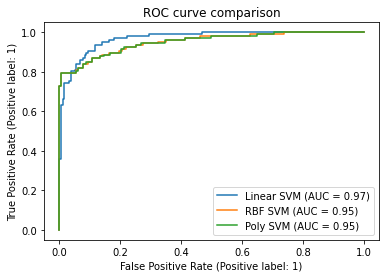

In [13]:
from sklearn.metrics import RocCurveDisplay
m1_roc=RocCurveDisplay.from_estimator(linear_svm, X_test, y_test, name='Linear SVM')
RocCurveDisplay.from_estimator(rbf_svm, X_test, y_test, ax = m1_roc.ax_, name='RBF SVM')
RocCurveDisplay.from_estimator(poly_svm, X_test, y_test, ax = m1_roc.ax_, name='Poly SVM')
plt.title("ROC curve comparison")
plt.show()

# linear SVM implementation in python

import required libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

Generate data

In [15]:
n = 100
p = 2

X0 = np.random.normal(loc = -2, scale = 1.5 , size = (n//2,p))
X1 = np.random.normal(loc = 2, scale = 1.5, size = (n//2,p))
X = np.concatenate([X0, X1])

## 1. Implemeting the SVM algorithm (Hard margin)

True hyper-plane (Decision boundary)

In [16]:
true_b = 0
true_w = np.array([2,2])

fx = true_b + np.matmul(X, true_w)
e = np.random.normal(scale = 1,size = n)
y = np.sign(fx)

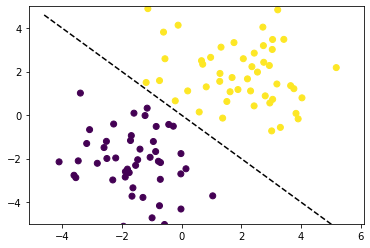

In [17]:
X0 = X[:,0]
X0_grid = np.arange(np.min(X0)-0.5, np.max(X0)+0.5, 0.1)
boundary = -true_b/true_w[1] - X0_grid * true_w[0]/true_w[1]

plt.scatter(X[:,0], X[:,1],c = y)
plt.plot(X0_grid, boundary, '--', color = 'black')
plt.ylim([-5,5])
plt.show()

In [37]:
#!pip install cvxopt

In [20]:
from cvxopt import solvers, matrix

CVXOPT solver and resulting $\alpha$

In [21]:
y = y.reshape(-1,1)
X_dash = y * X
H = np.dot(X_dash, X_dash.T)

In [22]:
# convert into cvxopt format
P = matrix(H)
q = matrix(-np.ones((n,1)))
G = matrix(-np.eye(n))
h = matrix(np.zeros(n))
A = matrix(y.reshape(1,-1))
b = matrix(np.zeros(1))

In [23]:
#setting solver paramters (change default to decrease tolerance)
epsilon = 1.0e-10

solvers.options['show_progress'] = False
solvers.options['abstol'] = epsilon
solvers.options['reltol'] = epsilon
solvers.options['reastol'] = epsilon

In [24]:
# Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

Compute $w$ and $b$ parameters

In [25]:
w = ((y * alphas).T @ X).reshape(-1,1)
_alpha = (alphas > epsilon).flatten()
b = y[_alpha] - np.dot(X[_alpha],w)

print('indices of support vectors = ', np.where(alphas > epsilon)[0])
print('w = ', w.flatten())
print('b = ', b[0])

indices of support vectors =  [29 78 96]
w =  [1.50305089 1.7364203 ]
b =  [0.1775722]


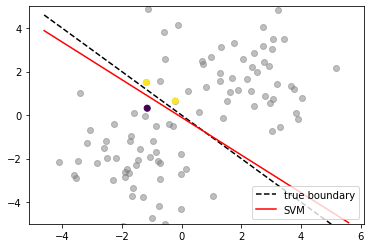

In [26]:
SVM_boundary = -b[0]/w[1] - X0_grid * w[0]/w[1]

plt.scatter(X[:,0], X[:,1],c = 'gray', alpha = 0.5)
plt.scatter(X[_alpha,0], X[_alpha,1],c = y[_alpha])

plt.plot(X0_grid, boundary, '--', color = "black", label = 'true boundary')
plt.plot(X0_grid, SVM_boundary, '-', color = "red", label = 'SVM')

plt.legend(loc = 'lower right')
plt.ylim([-5,5])
plt.show()

## 2. Implemeting the SVM algorithm (Soft margin)

True hyper-plane (Decision boundary)

In [27]:
e = np.random.normal(scale = 2,size = n)
y = np.sign(fx + e)

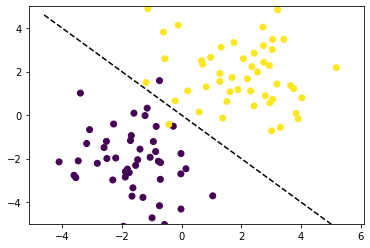

In [28]:
plt.scatter(X[:,0], X[:,1],c = y)
plt.plot(X0_grid, boundary, '--', color = 'black')
plt.ylim([-5,5])
plt.show()

CVXOPT solver and resulting $\alpha$

In [29]:
C = 10

In [30]:
y = y.reshape(-1,1)
X_dash = y * X
H = np.dot(X_dash, X_dash.T)

In [31]:
# convert into cvxopt format
P = matrix(H)
q = matrix(-np.ones((n,1)))
G = matrix(np.vstack((-np.eye(n), np.eye(n))))
h = matrix(np.hstack((-np.zeros(n), np.ones(n)*C)))
A = matrix(y.reshape(1,-1))
b = matrix(np.zeros(1))

In [32]:
# Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

Compute $w$ and $b$ parameters

In [33]:
w = ((y * alphas).T @ X).reshape(-1,1)
_alpha = (alphas > epsilon).flatten()
b = y[_alpha] - np.dot(X[_alpha],w)

print('indices of support vectors = ', np.where(alphas > epsilon)[0])
print('w = ', w.flatten())
print('b = ', b[0])

indices of support vectors =  [ 5 16 19 29 78 96]
w =  [1.54207553 1.62725293]
b =  [0.25727339]


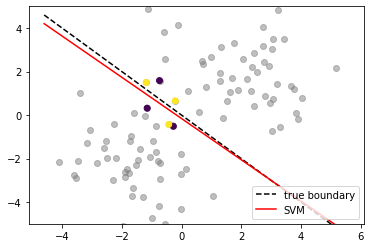

In [34]:
SVM_boundary = -b[0]/w[1] - X0_grid * w[0]/w[1]

plt.scatter(X[:,0], X[:,1],c = 'gray', alpha = 0.5)
plt.scatter(X[_alpha,0], X[_alpha,1],c = y[_alpha])

plt.plot(X0_grid, boundary, '--', color = "black", label = 'true boundary')
plt.plot(X0_grid, SVM_boundary, '-', color = "red", label = 'SVM')

plt.legend(loc = 'lower right')
plt.ylim([-5,5])
plt.show()

## Comparing to SKlearn results

In [35]:
from sklearn.svm import SVC

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)

w =  [[1.54181506 1.62798265]]
b =  [0.25701923]
Indices of support vectors =  [ 5 19 29 16 78 96]


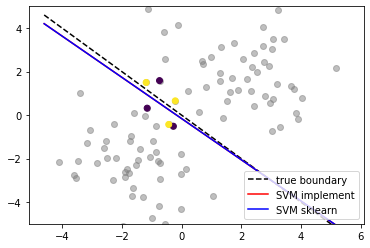

In [36]:
SVM_boundary_sklearn = -clf.intercept_[0]/clf.coef_[0][1] - X0_grid * clf.coef_[0][0]/clf.coef_[0][1]

plt.scatter(X[:,0], X[:,1],c = 'gray', alpha = 0.5)
plt.scatter(X[clf.support_,0], X[clf.support_,1],c = y[clf.support_])

plt.plot(X0_grid, boundary, '--', color = "black", label = 'true boundary')
plt.plot(X0_grid, SVM_boundary, '-', color = "red", label = 'SVM implement')
plt.plot(X0_grid, SVM_boundary_sklearn, '-', color = "blue", label = 'SVM sklearn')

plt.legend(loc = 'lower right')
plt.ylim([-5,5])
plt.show()

The end